In [25]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [26]:
dataset = 'model/keypoint.csv'
model_save_path = 'model/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier.tflite'

# Set number of classes

In [27]:
NUM_CLASSES = 6

# Dataset reading

In [28]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [ ]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
26/31 [========================>.....] - ETA: 0s - loss: 1.6422 - accuracy: 0.2458
Epoch 1: saving model to model\keypoint_classifier.hdf5
31/31 [==============================] - 5s 52ms/step - loss: 1.6238 - accuracy: 0.2494 - val_loss: 1.5022 - val_accuracy: 0.2589
Epoch 2/1000
30/31 [============================>.] - ETA: 0s - loss: 1.4708 - accuracy: 0.3047
Epoch 2: saving model to model\keypoint_classifier.hdf5
31/31 [==============================] - 1s 22ms/step - loss: 1.4703 - accuracy: 0.3058 - val_loss: 1.3817 - val_accuracy: 0.3941
Epoch 3/1000
28/31 [==========================>...] - ETA: 0s - loss: 1.3960 - accuracy: 0.3730
Epoch 3: saving model to model\keypoint_classifier.hdf5
31/31 [==============================] - 1s 19ms/step - loss: 1.3972 - accuracy: 0.3699 - val_loss: 1.2915 - val_accuracy: 0.5361
Epoch 4/1000
29/31 [===========================>..] - ETA: 0s - loss: 1.3286 - accuracy: 0.4095
Epoch 4: saving model to model\keypoint_classifier.hdf5
31

In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 6ms/step - loss: 0.2379 - accuracy: 0.9514


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 258ms/step
[2.5172105e-02 2.2109358e-02 7.7455206e-04 1.8614588e-07 9.5194381e-01]
4


# Confusion matrix

42/42 [==============================] - 1s 6ms/step


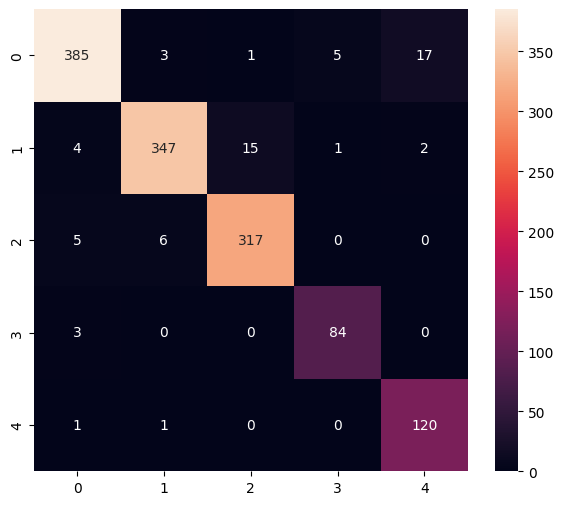

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       411
           1       0.97      0.94      0.96       369
           2       0.95      0.97      0.96       328
           3       0.93      0.97      0.95        87
           4       0.86      0.98      0.92       122

    accuracy                           0.95      1317
   macro avg       0.94      0.96      0.95      1317
weighted avg       0.95      0.95      0.95      1317



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\julii\AppData\Local\Temp\tmp1zjdtsro\assets


INFO:tensorflow:Assets written to: C:\Users\julii\AppData\Local\Temp\tmp1zjdtsro\assets


6588

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 6.17 ms


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.5172088e-02 2.2109374e-02 7.7455206e-04 1.8614554e-07 9.5194393e-01]
4
